# Spearman Ranking bioactivity of potential ligands with transglutaminase 2 (Celiac Disease)

*Ibrahim Wichka & Prof. Pin-Kuang Lai (Stevens Institute of Technology)*

Web App: [Insert Here]

Paper: [Insert Here]

## Step 1: Data Preprocessing

1.1: Import dataset and libraries and begin to clean dataset

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np

In [ ]:
!pip install rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
#----------------------------------------------------
import numpy as np
import pandas as pd

In [ ]:
import rdkit
print(rdkit.__version__)


2024.03.4


*** Note: The following cell contains instructions that do not need to be done to go through this tutorial. I am simply including it for the purpose of articulating data finding techniques

We must use a dataset from a biological assay of compounds tested against transglutaminase 2 (TG2). Many of these can be found on databases like:

CHEMBL (https://www.ebi.ac.uk/chembl/)
PubChem (https://pubchem.ncbi.nlm.nih.gov/)

We can get our dataset from Pubchem's TG2 assays and download a csv of it:

Pubchem Data Link:(https://pubchem.ncbi.nlm.nih.gov/gene/7052#section=Chemicals-and-Bioactivities&fullscreen=true)

CSV File: https://drive.google.com/file/d/118BhVnxCtB6jjo44cHrxVrKo_mYI4WWQ/view?usp=sharing


This dataset contains many columns but the only ones that we will really need are CID, Compound_Name, Type, Value, and Activity.

One thing not present in the dataset are the SMILES notation for all the molecules. These can be extracted from pubhcem manually put because our dataset is so large, this would be time consuming.

We can use the pubchempy api to get the smiles of all the molecules in the dataset. Here is a link to a notebook with a demonstration of this.

*** Note: The following instructions are mandatory.

For this tutorial simply download the file:  

CSV File: https://drive.google.com/file/d/1AJdjYbAE3cMFliJOib3Dc_u86JXn5-au/view?usp=sharing


Place it into the sample data for your demo of this tutorial.

You are now ready to do some bioactivity predictions!

Store the csv in a dataframe.

In [ ]:
df_master = pd.read_csv('TG2_compound_smiles.csv')
df_master

,CID,Compound_Name,Type,Value,Activity,Acqual,Smiles
0,28254071,"(6-Methyl-4-oxo-3,5-diphenyl-3,4-dihydro-thien...",IC50,0.16,Active,=,CC1=C(C2=C(S1)N=C(N(C2=O)C3=CC=CC=C3)SCC(=O)NN...
1,44391427,"2-[[3-(3-Fluorophenyl)-4-oxo-5-phenyl-5,6,7,8-...",IC50,0.17,Active,=,C1CC(C2=C(C1)SC3=C2C(=O)N(C(=N3)SCC(=O)NN)C4=C...
2,11784890,[6-Chloro-3-(3-fluoro-phenyl)-5-(2-fluoro-phen...,IC50,0.13,Active,=,C1=CC=C(C(=C1)C2=C(SC3=C2C(=O)N(C(=N3)SCC(=O)N...
3,44391463,[3-(3-Fluoro-phenyl)-5-(4-methoxy-phenyl)-4-ox...,IC50,0.28,Active,=,COC1=CC=C(C=C1)C2=CSC3=C2C(=O)N(C(=N3)SCC(=O)N...
4,1150683,"2-(4-Oxo-3,5-diphenylthieno[2,3-d]pyrimidin-2-...",IC50,0.25,Active,=,C1=CC=C(C=C1)C2=CSC3=C2C(=O)N(C(=N3)SCC(=O)NN)...
...,...,...,...,...,...,...,...
1125,5387156,(2E)-3-(3-nitrophenyl)-1-(pyridin-3-yl)prop-2-...,IC50,19.60,Unspecified,=,C1=CC(=CC(=C1)[N+](=O)[O-])C=CC(=O)C2=CN=CC=C2
1126,72950407,T4SR539Ykf,IC50,0.01,Unspecified,>,CCC(CC)CNC(=O)CN1C=CC=C(C1=O)NC(=O)C(CCC=CC(=O...
1127,146197612,Ac-Asn-Abu(Unk)-Glu-Gln-Val-Ser-Pro-Leu-OH,IC50,0.01,Unspecified,>,CC(C)CC(C(=O)O)NC(=O)C1CCCN1C(=O)C(CO)NC(=O)C(...
1128,146213718,"(2S)-1-[(2S)-2-[[(2S)-2-[[(2S)-2-[[(E,2S)-7-me...",IC50,0.01,Unspecified,>,CCCCC(C(=O)NC(C(C)CC)C(=O)NC(CC(C)C)C(=O)N1CCC...


We must first remove all duplicates from our dataset. Drug design biologists tend to perform repeated trials of a molecules but we will only need one trial and it will be better for training our model.

Depending on the method of smiles extraction you may have either isomeric or canonical smiles notations for your molecules.

We will either remove duplicates based on CID or SMILES based on some analysis. This an only be done with the distinctive canonical smiles.

We can convert each smiles notation to its canonical using the following.

In [ ]:
def canonical_smiles(smiles):
    mols = [Chem.MolFromSmiles(smi) for smi in smiles]
    smiles = [Chem.MolToSmiles(mol) for mol in mols]
    return smiles

Canon_SMILES = canonical_smiles(df_master.Smiles)
df_master["Smiles"] = Canon_SMILES
df_master

,CID,Compound_Name,Type,Value,Activity,Acqual,Smiles
0,28254071,"(6-Methyl-4-oxo-3,5-diphenyl-3,4-dihydro-thien...",IC50,0.16,Active,=,Cc1sc2nc(SCC(=O)NN)n(-c3ccccc3)c(=O)c2c1-c1ccccc1
1,44391427,"2-[[3-(3-Fluorophenyl)-4-oxo-5-phenyl-5,6,7,8-...",IC50,0.17,Active,=,NNC(=O)CSc1nc2sc3c(c2c(=O)n1-c1cccc(F)c1)C(c1c...
2,11784890,[6-Chloro-3-(3-fluoro-phenyl)-5-(2-fluoro-phen...,IC50,0.13,Active,=,NNC(=O)CSc1nc2sc(Cl)c(-c3ccccc3F)c2c(=O)n1-c1c...
3,44391463,[3-(3-Fluoro-phenyl)-5-(4-methoxy-phenyl)-4-ox...,IC50,0.28,Active,=,COc1ccc(-c2csc3nc(SCC(=O)NN)n(-c4cccc(F)c4)c(=...
4,1150683,"2-(4-Oxo-3,5-diphenylthieno[2,3-d]pyrimidin-2-...",IC50,0.25,Active,=,NNC(=O)CSc1nc2scc(-c3ccccc3)c2c(=O)n1-c1ccccc1
...,...,...,...,...,...,...,...
1125,5387156,(2E)-3-(3-nitrophenyl)-1-(pyridin-3-yl)prop-2-...,IC50,19.60,Unspecified,=,O=C(C=Cc1cccc([N+](=O)[O-])c1)c1cccnc1
1126,72950407,T4SR539Ykf,IC50,0.01,Unspecified,>,CCC(CC)CNC(=O)Cn1cccc(NC(=O)C(CCC=CC(=O)OC)NC(...
1127,146197612,Ac-Asn-Abu(Unk)-Glu-Gln-Val-Ser-Pro-Leu-OH,IC50,0.01,Unspecified,>,COC(=O)C=CCCC(NC(=O)C(CC(N)=O)NC(C)=O)C(=O)NC(...
1128,146213718,"(2S)-1-[(2S)-2-[[(2S)-2-[[(2S)-2-[[(E,2S)-7-me...",IC50,0.01,Unspecified,>,CCCCC(NC(=O)C(CCC=CC(=O)OC)NC(=O)C1CC(=O)CN1)C...


For now, let's remove duplicates based on CID. We will get to know whether this was the right move later.

In [ ]:
df = df_master.drop_duplicates(subset='CID')
df2 = df.reset_index(drop = True)
df2

,CID,Compound_Name,Type,Value,Activity,Acqual,Smiles
0,28254071,"(6-Methyl-4-oxo-3,5-diphenyl-3,4-dihydro-thien...",IC50,0.16,Active,=,Cc1sc2nc(SCC(=O)NN)n(-c3ccccc3)c(=O)c2c1-c1ccccc1
1,44391427,"2-[[3-(3-Fluorophenyl)-4-oxo-5-phenyl-5,6,7,8-...",IC50,0.17,Active,=,NNC(=O)CSc1nc2sc3c(c2c(=O)n1-c1cccc(F)c1)C(c1c...
2,11784890,[6-Chloro-3-(3-fluoro-phenyl)-5-(2-fluoro-phen...,IC50,0.13,Active,=,NNC(=O)CSc1nc2sc(Cl)c(-c3ccccc3F)c2c(=O)n1-c1c...
3,44391463,[3-(3-Fluoro-phenyl)-5-(4-methoxy-phenyl)-4-ox...,IC50,0.28,Active,=,COc1ccc(-c2csc3nc(SCC(=O)NN)n(-c4cccc(F)c4)c(=...
4,1150683,"2-(4-Oxo-3,5-diphenylthieno[2,3-d]pyrimidin-2-...",IC50,0.25,Active,=,NNC(=O)CSc1nc2scc(-c3ccccc3)c2c(=O)n1-c1ccccc1
...,...,...,...,...,...,...,...
667,145951882,3-[2-[(E)-2-(3-nitrophenyl)ethenyl]oxiran-2-yl...,IC50,151.00,Unspecified,=,O=[N+]([O-])c1cccc(C=CC2(c3cccnc3)CO2)c1
668,145955913,4-[[4-[1-[(4-Nitrophenyl)methyl]triazole-4-car...,IC50,100.00,Unspecified,>,N#Cc1ccc(Cn2cc(C(=O)c3cn(Cc4ccc([N+](=O)[O-])c...
669,145962928,3-(Benzotriazole-1-carbonyl)-6-nitrochromen-2-one,IC50,145.00,Unspecified,=,O=C(c1cc2cc([N+](=O)[O-])ccc2oc1=O)n1nnc2ccccc21
670,145959648,[1-[(3-Nitrophenyl)methyl]triazol-4-yl]-[1-[(4...,IC50,100.00,Unspecified,>,O=C(c1cn(Cc2ccc([N+](=O)[O-])cc2)nn1)c1cn(Cc2c...


In [ ]:
df2 = df2[df2["Value"] <= 10]
df2 = df2.reset_index(drop = True)
df100 = df2
df2

,CID,Compound_Name,Type,Value,Activity,Acqual,Smiles
0,28254071,"(6-Methyl-4-oxo-3,5-diphenyl-3,4-dihydro-thien...",IC50,0.160,Active,=,Cc1sc2nc(SCC(=O)NN)n(-c3ccccc3)c(=O)c2c1-c1ccccc1
1,44391427,"2-[[3-(3-Fluorophenyl)-4-oxo-5-phenyl-5,6,7,8-...",IC50,0.170,Active,=,NNC(=O)CSc1nc2sc3c(c2c(=O)n1-c1cccc(F)c1)C(c1c...
2,11784890,[6-Chloro-3-(3-fluoro-phenyl)-5-(2-fluoro-phen...,IC50,0.130,Active,=,NNC(=O)CSc1nc2sc(Cl)c(-c3ccccc3F)c2c(=O)n1-c1c...
3,44391463,[3-(3-Fluoro-phenyl)-5-(4-methoxy-phenyl)-4-ox...,IC50,0.280,Active,=,COc1ccc(-c2csc3nc(SCC(=O)NN)n(-c4cccc(F)c4)c(=...
4,1150683,"2-(4-Oxo-3,5-diphenylthieno[2,3-d]pyrimidin-2-...",IC50,0.250,Active,=,NNC(=O)CSc1nc2scc(-c3ccccc3)c2c(=O)n1-c1ccccc1
...,...,...,...,...,...,...,...
419,166178144,NaN,IC50,0.141,Active,NaN,COC(=O)C=CCCC(NC(=O)c1cc([N+](=O)[O-])ccc1C(=O...
420,146209787,"2-[[(E,2S)-1-[[1-[2-[(2S)-2-[[(2S)-1-[(2S)-2-c...",IC50,7.040,Active,NaN,COC(=O)C=CCCC(NC(=O)c1ccccc1C(=O)O)C(=O)Nc1ccc...
421,146209921,"2-[[(E,2S)-1-[[(2S)-1-[[1-[2-[[(2S)-1-[(2S)-2-...",IC50,10.000,Inactive,>,CCCCC(NC(=O)C(CCC=CC(=O)OC)NC(=O)c1ccccc1C(=O)...
422,146210039,"2-[[(E,2S)-1-[[(2S)-1-[[1-[2-[(2S)-2-[[(2S)-1-...",IC50,10.000,Inactive,>,CCCCC(NC(=O)C(CCC=CC(=O)OC)NC(=O)c1ccccc1C(=O)...


In [ ]:
df2 = df2.drop(["CID", "Compound_Name", "Type", "Activity", "Acqual"], axis = 1)
df2

,Value,Smiles
0,0.160,Cc1sc2nc(SCC(=O)NN)n(-c3ccccc3)c(=O)c2c1-c1ccccc1
1,0.170,NNC(=O)CSc1nc2sc3c(c2c(=O)n1-c1cccc(F)c1)C(c1c...
2,0.130,NNC(=O)CSc1nc2sc(Cl)c(-c3ccccc3F)c2c(=O)n1-c1c...
3,0.280,COc1ccc(-c2csc3nc(SCC(=O)NN)n(-c4cccc(F)c4)c(=...
4,0.250,NNC(=O)CSc1nc2scc(-c3ccccc3)c2c(=O)n1-c1ccccc1
...,...,...
419,0.141,COC(=O)C=CCCC(NC(=O)c1cc([N+](=O)[O-])ccc1C(=O...
420,7.040,COC(=O)C=CCCC(NC(=O)c1ccccc1C(=O)O)C(=O)Nc1ccc...
421,10.000,CCCCC(NC(=O)C(CCC=CC(=O)OC)NC(=O)c1ccccc1C(=O)...
422,10.000,CCCCC(NC(=O)C(CCC=CC(=O)OC)NC(=O)c1ccccc1C(=O)...


In [ ]:
df10 = pd.DataFrame()
df10["smiles"] = df2["Smiles"]
df10["Value"] = df2["Value"]
df10.to_csv('reg_fing_desc.csv', index = False)

## Step 2: Getting Molecular Fingerprints & Descriptors

2.1: Generate rdkit fingerprints to serve as features that our model will learn off of

Molecular fingerprints are binary variables that indicate the presence of a certain functional group or substructure in a molecule. Because the bioactivity of a drug primarily depends on its properties, fingerprints are an excellent tool to aid our model in predicting the activity of molecules it has never seen before

Generate a visualized structure for each molecule using its SMILES. This will be used to calculate the actual fingerprints.

In [ ]:
from rdkit.Chem import PandasTools
PandasTools.AddMoleculeColumnToFrame(df2,'Smiles', 'Structure')

,Value,Smiles,Structure
0,0.160,Cc1sc2nc(SCC(=O)NN)n(-c3ccccc3)c(=O)c2c1-c1ccccc1,
1,0.170,NNC(=O)CSc1nc2sc3c(c2c(=O)n1-c1cccc(F)c1)C(c1c...,
2,0.130,NNC(=O)CSc1nc2sc(Cl)c(-c3ccccc3F)c2c(=O)n1-c1c...,
3,0.280,COc1ccc(-c2csc3nc(SCC(=O)NN)n(-c4cccc(F)c4)c(=...,
4,0.250,NNC(=O)CSc1nc2scc(-c3ccccc3)c2c(=O)n1-c1ccccc1,
...,...,...,...
419,0.141,COC(=O)C=CCCC(NC(=O)c1cc([N+](=O)[O-])ccc1C(=O...,
420,7.040,COC(=O)C=CCCC(NC(=O)c1ccccc1C(=O)O)C(=O)Nc1ccc...,
421,10.000,CCCCC(NC(=O)C(CCC=CC(=O)OC)NC(=O)c1ccccc1C(=O)...,
422,10.000,CCCCC(NC(=O)C(CCC=CC(=O)OC)NC(=O)c1ccccc1C(=O)...,

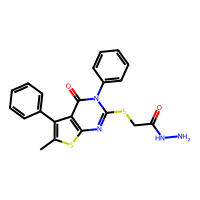
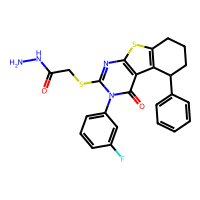
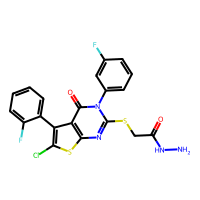
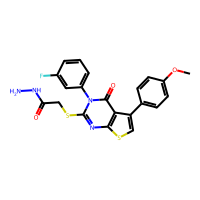
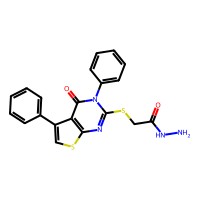
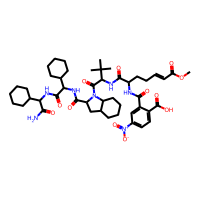
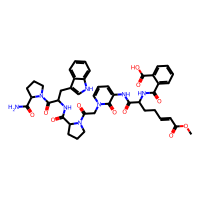
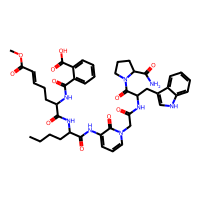
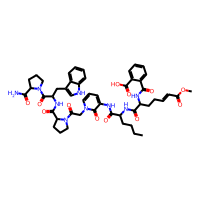
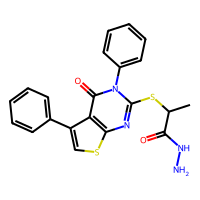

In [ ]:
df2

Import necessary fingerprint libaries and write a function that calculates all fingerprints and stores in a numpy array

In [ ]:
from rdkit.Chem.inchi import MolBlockToInchi
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import MACCSkeys
def generate_fpts(data):

    Rdk_fpts = []

    rdkbi_list= []

    onbit_list = []

    for smiles in data["Smiles"]:
        mol = Chem.MolFromSmiles(smiles)
        rdkbi = {}
        Rdk = AllChem.RDKFingerprint(mol, maxPath=5, fpSize=512, bitInfo=rdkbi)
        Rdk_fpts.append(Rdk)
        rdkbi_list.append(rdkbi)
        onbit_list.append(list(Rdk.GetOnBits())[:10])


    return pd.DataFrame(np.array(Rdk_fpts)), rdkbi_list, rdkbi, onbit_list

In [ ]:
df3, rdkbi_list, rdkbi, onbit_list = generate_fpts(df2)
df3 = pd.DataFrame(df3)
df3

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,1,1,1,1,0,1,1,0,1,1,...,1,1,0,1,0,0,1,0,1,1
1,1,1,1,1,1,1,1,0,1,1,...,1,1,1,1,0,0,1,0,1,1
2,1,1,1,1,0,1,1,0,1,1,...,1,0,0,1,0,0,1,0,1,1
3,1,1,1,1,0,1,1,0,1,1,...,1,0,0,1,0,0,1,0,1,1
4,1,1,1,1,0,1,1,0,1,1,...,1,0,0,1,0,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,0,1,1,1,1,1,1,0,0,1,...,0,0,0,1,1,0,1,1,0,1
420,1,1,1,1,1,1,1,0,1,1,...,0,1,1,1,1,1,1,1,1,1
421,1,1,1,1,1,1,1,0,1,1,...,0,1,1,1,1,1,1,1,1,1
422,1,1,1,1,1,1,1,0,1,1,...,0,1,1,1,1,1,1,1,1,1


Call the fingerprint generation function and convert to a dataframe

You will now be able to observe the binary values of the fingerprints. A "1" indicates the presence of a certain substructure while "0" indicates the absence

2.2: Remove correlated and low_variance fingerprint features

Although each fingerprint may represent a distinct substructure, the presence of a fingerprint may be dependent on the presence of another indicating that the dependent fingerprint is simply an unncessary extra parameter for our model to learn off of. These can be removed by writing a quick function that deletes highly correlated features.

That is not to say that correlation is not important when discussing bioactivity but the most important relationships in feature analysis are between INDEPENDENT features that are moderately related and contribute in combination with each other towards activity rather than directly affect each other.

Fingerprints can also be classified as "low variance" if its presence or absence is fairly prominent throughout the set indicating that it is not a distinguishable factor. These can also be removed.

In [ ]:
def remove_correlated_features(descriptors):

    correlated_matrix = descriptors.corr().abs()


    upper_triangle = correlated_matrix.where(np.triu(np.ones(correlated_matrix.shape),k=1).astype(bool))


    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] >= 0.9)]
    descriptors_correlated_dropped = descriptors.drop(columns=to_drop, axis=1)
    return descriptors_correlated_dropped, to_drop

fingerprints_new, to_drop = remove_correlated_features(df3)
from sklearn.feature_selection import VarianceThreshold

def remove_low_variance(input_data, threshold=0.1):
    selection = VarianceThreshold(threshold)
    selection.fit(input_data)
    selected_indices = selection.get_support(indices=True)
    removed_indices = [i for i in range(input_data.shape[1]) if i not in selected_indices]
    return input_data[input_data.columns[selection.get_support(indices=True)]], removed_indices

df5, removed_indices = remove_low_variance(fingerprints_new, threshold=0.1)
df5

,0,1,3,4,5,6,7,8,9,10,...,500,501,502,503,504,505,506,507,509,510
0,1,1,1,0,1,1,0,1,1,1,...,1,1,1,1,0,1,0,0,0,1
1,1,1,1,1,1,1,0,1,1,1,...,1,1,1,1,1,1,0,0,0,1
2,1,1,1,0,1,1,0,1,1,1,...,1,1,1,0,0,1,0,0,0,1
3,1,1,1,0,1,1,0,1,1,1,...,1,1,1,0,0,1,0,0,0,1
4,1,1,1,0,1,1,0,1,1,1,...,1,1,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,0,1,1,1,1,1,0,0,1,1,...,1,1,0,0,0,1,1,0,1,0
420,1,1,1,1,1,1,0,1,1,1,...,1,1,0,1,1,1,1,1,1,1
421,1,1,1,1,1,1,0,1,1,1,...,1,1,0,1,1,1,1,1,1,1
422,1,1,1,1,1,1,0,1,1,1,...,1,1,0,1,1,1,1,1,1,1


In [ ]:
all_drops = to_drop + removed_indices
all_drops

[330,
 342,
 408,
 495,
 2,
 16,
 29,
 40,
 51,
 64,
 65,
 81,
 87,
 103,
 112,
 117,
 141,
 142,
 161,
 186,
 194,
 209,
 211,
 233,
 236,
 238,
 248,
 265,
 280,
 284,
 290,
 294,
 297,
 308,
 312,
 341,
 351,
 369,
 371,
 372,
 379,
 386,
 402,
 409,
 411,
 415,
 416,
 427,
 442,
 446,
 459,
 466,
 473,
 478,
 490,
 504,
 507]

In [ ]:
from rdkit.Chem import Descriptors
def getMolDescriptors(mol, missingVal=None):
    res = {}
    for nm,fn in Descriptors._descList:
        try:
            val = fn(mol)
        except:
            import traceback
            traceback.print_exc()
            val = missingVal
        res[nm] = val
    return res

mols_desc = [Chem.MolFromSmiles(molecule) for molecule in df2["Smiles"]]
allDescrs = [getMolDescriptors(molecule) for molecule in mols_desc]
print(allDescrs[0])
df10 = pd.DataFrame(allDescrs)
df10

[17:18:27] DEPRECATION WARNING: please use MorganGenerator
[17:18:27] DEPRECATION WARNING: please use MorganGenerator
[17:18:27] DEPRECATION WARNING: please use MorganGenerator
[17:18:27] DEPRECATION WARNING: please use MorganGenerator
[17:18:27] DEPRECATION WARNING: please use MorganGenerator
[17:18:27] DEPRECATION WARNING: please use MorganGenerator
[17:18:27] DEPRECATION WARNING: please use MorganGenerator
[17:18:27] DEPRECATION WARNING: please use MorganGenerator
[17:18:27] DEPRECATION WARNING: please use MorganGenerator
[17:18:27] DEPRECATION WARNING: please use MorganGenerator
[17:18:27] DEPRECATION WARNING: please use MorganGenerator
[17:18:27] DEPRECATION WARNING: please use MorganGenerator
[17:18:27] DEPRECATION WARNING: please use MorganGenerator
[17:18:27] DEPRECATION WARNING: please use MorganGenerator
[17:18:27] DEPRECATION WARNING: please use MorganGenerator
[17:18:27] DEPRECATION WARNING: please use MorganGenerator
[17:18:27] DEPRECATION WARNING: please use MorganGenerat

{'MaxAbsEStateIndex': 13.66247756046863, 'MaxEStateIndex': 13.66247756046863, 'MinAbsEStateIndex': 0.06664685337710274, 'MinEStateIndex': -0.33676636061015564, 'qed': 0.16889551811432496, 'SPS': 10.96551724137931, 'MolWt': 422.53500000000014, 'HeavyAtomMolWt': 404.3910000000003, 'ExactMolWt': 422.08711781599993, 'NumValenceElectrons': 146, 'NumRadicalElectrons': 0, 'MaxPartialCharge': 0.26766048455072816, 'MinPartialCharge': -0.29353901983396175, 'MaxAbsPartialCharge': 0.29353901983396175, 'MinAbsPartialCharge': 0.26766048455072816, 'FpDensityMorgan1': 1.1379310344827587, 'FpDensityMorgan2': 1.793103448275862, 'FpDensityMorgan3': 2.4482758620689653, 'BCUT2D_MWHI': 32.166604971063634, 'BCUT2D_MWLOW': 10.041415538396658, 'BCUT2D_CHGHI': 2.207432402916392, 'BCUT2D_CHGLO': -2.1208297256210162, 'BCUT2D_LOGPHI': 2.3638951378082345, 'BCUT2D_LOGPLOW': -2.3156371655017427, 'BCUT2D_MRHI': 7.9936793524962475, 'BCUT2D_MRLOW': -0.11812254212384232, 'AvgIpc': 3.089375726648802, 'BalabanJ': 1.9915576

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,13.662478,13.662478,0.066647,-0.336766,0.168896,10.965517,422.535,404.391,422.087118,146,...,1,0,0,0,0,0,0,1,0,0
1,14.074317,14.074317,0.012408,-0.454021,0.147360,15.393939,480.590,459.422,480.108996,168,...,1,0,0,0,0,0,0,1,0,0
2,14.503540,14.503540,0.108322,-0.562352,0.147926,11.096774,478.933,465.829,478.013652,158,...,1,0,0,0,0,0,0,1,0,0
3,13.921419,13.921419,0.041196,-0.485329,0.151802,10.935484,456.524,439.388,456.072611,158,...,1,0,0,0,0,0,0,1,0,0
4,13.510255,13.510255,0.067657,-0.337859,0.174011,10.892857,408.508,392.380,408.071468,140,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,15.191392,15.191392,0.024830,-1.541048,0.052291,22.181818,922.090,854.554,921.484771,362,...,0,0,0,0,0,0,0,0,0,0
420,14.057530,14.057530,0.073195,-1.360137,0.065355,16.968254,864.913,816.529,864.344254,330,...,0,0,0,0,0,0,0,0,0,0
421,13.952842,13.952842,0.063619,-1.358617,0.047046,14.906250,880.956,828.540,880.375554,338,...,0,0,0,0,0,0,0,0,1,0
422,14.123669,14.123669,0.070361,-1.362926,0.044052,16.760563,978.073,918.601,977.428318,376,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
df4 = pd.concat([df5, df10, df2], axis=1)
# df4 = pd.concat([df10, df2], axis=1)
# df4 = pd.concat([df5, df2], axis=1)
df4.drop(['Smiles', 'Structure'], axis = 1, inplace = True)
df4

,0,1,3,4,5,6,7,8,9,10,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,Value
0,1,1,1,0,1,1,0,1,1,1,...,0,0,0,0,0,0,1,0,0,0.160
1,1,1,1,1,1,1,0,1,1,1,...,0,0,0,0,0,0,1,0,0,0.170
2,1,1,1,0,1,1,0,1,1,1,...,0,0,0,0,0,0,1,0,0,0.130
3,1,1,1,0,1,1,0,1,1,1,...,0,0,0,0,0,0,1,0,0,0.280
4,1,1,1,0,1,1,0,1,1,1,...,0,0,0,0,0,0,1,0,0,0.250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,0,1,1,1,1,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0.141
420,1,1,1,1,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,7.040
421,1,1,1,1,1,1,0,1,1,1,...,0,0,0,0,0,0,0,1,0,10.000
422,1,1,1,1,1,1,0,1,1,1,...,0,0,0,0,0,0,0,1,0,10.000


In [ ]:
from sklearn.feature_selection import VarianceThreshold

def variance_threshold_selector(data, threshold):
    # Separate features and target variable
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]

    # Create VarianceThreshold object
    selector = VarianceThreshold(threshold)

    X.columns = X.columns.astype(str)

    # Fit selector to data
    selector.fit(X)

    # Get indices of features to keep
    indices_to_keep = selector.get_support(indices=True)

    # Filter features
    selected_features = X.columns[indices_to_keep]
    X_filtered = selector.transform(X)
    X_filtered_df = pd.DataFrame(X_filtered, columns=selected_features)

    # Concatenate filtered features with target variable
    filtered_data = pd.concat([X_filtered_df, y], axis=1)

    return filtered_data

filtered_df4 = variance_threshold_selector(df4, 0.2)
filtered_df4

,0,4,5,6,7,8,10,11,12,14,...,fr_amide,fr_aniline,fr_benzene,fr_bicyclic,fr_ester,fr_ether,fr_halogen,fr_piperzine,fr_pyridine,Value
0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.160
1,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,2.0,3.0,0.0,0.0,1.0,0.0,0.0,0.170
2,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,2.0,1.0,0.0,0.0,3.0,0.0,0.0,0.130
3,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,2.0,1.0,0.0,1.0,1.0,0.0,0.0,0.280
4,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,6.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.141
420,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,...,6.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,1.0,7.040
421,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,...,6.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,1.0,10.000
422,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,...,7.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,1.0,10.000


In [ ]:
from sklearn.ensemble import RandomForestRegressor

def random_forest_feature_importance_selector(data, n_features_to_select):
    # Separate features and target variable
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]

    # Convert feature names to strings
    X.columns = X.columns.astype(str)

    # Train a Random Forest classifier
    clf = RandomForestRegressor()
    clf.fit(X, y)

    # Get feature importances
    feature_importances = clf.feature_importances_

    # Sort feature importances in descending order and get indices of top features
    top_feature_indices = feature_importances.argsort()[::-1][:n_features_to_select]

    # Get selected features
    selected_features = X.columns[top_feature_indices]

    # Filter features
    X_filtered = X.iloc[:, top_feature_indices]

    # Concatenate filtered features with target variable
    filtered_data = pd.concat([X_filtered, y], axis=1)

    return filtered_data


n_features_to_select = 400  # Set the number of features to select
tree_filtered_df4 = random_forest_feature_importance_selector(filtered_df4, n_features_to_select)
# tree_filtered_df4 = random_forest_feature_importance_selector(df4, n_features_to_select)
tree_filtered_df4

,EState_VSA2,SPS,BCUT2D_MRHI,SMR_VSA7,MolLogP,EState_VSA5,BalabanJ,BCUT2D_MWHI,VSA_EState6,VSA_EState5,...,215,SlogP_VSA7,434,184,417,155,188,332,12,Value
0,17.219300,10.965517,7.993679,75.894622,3.50462,23.098671,1.991558,32.166605,19.170076,4.923531,...,1.0,0.000000,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.160
1,17.230027,15.393939,7.993681,86.772379,4.13650,38.477218,1.751621,32.166605,16.045652,4.464620,...,1.0,0.000000,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.170
2,42.276529,11.096774,7.993686,74.855511,4.12780,47.031669,2.028227,35.496018,11.322583,3.418045,...,1.0,4.336329,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.130
3,16.468557,10.935484,7.993678,70.082024,3.34390,34.102987,1.924671,32.166605,13.023698,4.912319,...,1.0,0.000000,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.280
4,17.219300,10.892857,7.993676,76.397538,3.19620,23.098671,1.943801,32.166605,19.064346,4.903585,...,1.0,0.000000,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,36.637202,22.181818,6.065298,51.592363,4.20690,13.185818,1.435168,16.628547,-3.295710,-6.668471,...,1.0,0.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.141
420,49.042332,16.968254,6.067169,112.253557,1.46910,65.580683,1.160558,16.522748,11.419535,-5.984410,...,1.0,0.000000,1.0,0.0,1.0,1.0,0.0,1.0,0.0,7.040
421,49.042332,14.906250,6.061379,112.253557,2.15310,60.680773,1.316832,16.522745,11.153385,-6.284551,...,1.0,0.000000,1.0,0.0,1.0,1.0,0.0,1.0,0.0,10.000
422,62.007910,16.760563,6.062087,112.253557,2.14410,65.580683,1.145664,16.522780,10.242756,-6.720915,...,1.0,0.000000,1.0,0.0,1.0,1.0,0.0,1.0,0.0,10.000


In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

def rfe_selector_regression(data, n_features_to_select):
    # Separate features and target variable
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]

    # Convert feature names to strings
    X.columns = X.columns.astype(str)

    # Choose a regression estimator (e.g., Linear Regression)
    estimator = LinearRegression()

    # Create RFE object with a larger step size (e.g., step=10)
    rfe = RFE(estimator, n_features_to_select = n_features_to_select, step=10)

    # Fit RFE to data
    rfe.fit(X, y)

    # Get selected features
    selected_features = X.columns[rfe.support_]

    # Filter features
    X_filtered = rfe.transform(X)
    X_filtered_df = pd.DataFrame(X_filtered, columns=selected_features)

    # Concatenate filtered features with target variable
    filtered_data = pd.concat([X_filtered_df, y], axis=1)

    return filtered_data


n_features_to_select = 200  # Set the number of features to select
rfe_filtered_df4 = rfe_selector_regression(tree_filtered_df4, n_features_to_select)
# rfe_filtered_df4 = rfe_selector_regression(filtered_df4, n_features_to_select)
rfe_filtered_df4

,EState_VSA2,MolLogP,EState_VSA5,BalabanJ,EState_VSA3,PEOE_VSA8,Chi4v,EState_VSA4,PEOE_VSA7,Chi3v,...,331,318,75,257,157,217,263,332,12,Value
0,17.219300,3.50462,23.098671,1.991558,21.060443,10.440599,5.078591,16.004050,24.619923,6.378991,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.160
1,17.230027,4.13650,38.477218,1.751621,21.060443,10.795053,6.533867,36.587801,48.588469,7.913491,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.170
2,42.276529,4.12780,47.031669,2.028227,0.000000,11.126903,5.218294,23.098671,24.265468,6.586199,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.130
3,16.468557,3.34390,34.102987,1.924671,21.653519,10.943514,4.878994,22.888788,35.895287,6.348626,...,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.280
4,17.219300,3.19620,23.098671,1.943801,21.060443,10.943514,4.687982,11.126903,17.696186,5.980389,...,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,36.637202,4.20690,13.185818,1.435168,25.683286,24.250595,10.333393,94.904159,87.022470,13.859681,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.141
420,49.042332,1.46910,65.580683,1.160558,25.807221,48.882967,7.948455,27.109496,74.420217,11.138327,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,7.040
421,49.042332,2.15310,60.680773,1.316832,25.683286,42.338210,7.450251,27.109496,67.999395,10.768938,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,10.000
422,62.007910,2.14410,65.580683,1.145664,32.104108,48.882967,8.897827,27.109496,80.841038,12.617659,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,10.000


In [ ]:
df96 = pd.concat([df100, df2, df4], axis=1)
df96.drop(["CID", "Type", "Value", "Acqual", "Value", "Structure"], inplace = True, axis = 1)

df4 = rfe_filtered_df4
print(df4.columns.tolist())
print(len(df4.columns.tolist()))
df96.to_csv('TG2_regression_train_test.csv', index = False)
df96

['EState_VSA2', 'MolLogP', 'EState_VSA5', 'BalabanJ', 'EState_VSA3', 'PEOE_VSA8', 'Chi4v', 'EState_VSA4', 'PEOE_VSA7', 'Chi3v', 'EState_VSA6', 'NumSaturatedRings', 'NumSaturatedHeterocycles', 'VSA_EState7', 'SMR_VSA6', 'EState_VSA8', 'EState_VSA7', 'VSA_EState1', 'PEOE_VSA6', '454', 'Chi2v', 'SMR_VSA1', 'SMR_VSA3', 'SlogP_VSA5', '143', 'EState_VSA9', 'HeavyAtomMolWt', 'PEOE_VSA14', '355', 'Kappa2', 'SMR_VSA5', 'PEOE_VSA12', 'Chi4n', 'PEOE_VSA10', 'SlogP_VSA12', 'EState_VSA1', 'Chi3n', 'NumHDonors', '14', 'PEOE_VSA9', 'Chi1v', 'RingCount', '177', '466', 'Chi0v', 'SlogP_VSA10', '67', '327', 'Chi0n', '84', 'fr_bicyclic', 'fr_NH1', 'SMR_VSA4', 'LabuteASA', '33', 'PEOE_VSA13', 'NumHeteroatoms', '509', '88', '52', '147', '96', 'HeavyAtomCount', '366', '483', 'SlogP_VSA8', 'PEOE_VSA11', '383', 'MolMR', '204', '360', '151', 'fr_NH0', '156', '406', '264', 'ExactMolWt', '356', '288', '498', 'MolWt', '126', 'fr_amide', 'NOCount', '451', '34', '479', 'Chi0', 'NumAromaticHeterocycles', '73', '4', '

,Compound_Name,Activity,Smiles,Smiles,EState_VSA2,MolLogP,EState_VSA5,BalabanJ,EState_VSA3,PEOE_VSA8,...,422,331,318,75,257,157,217,263,332,12
0,"(6-Methyl-4-oxo-3,5-diphenyl-3,4-dihydro-thien...",Active,Cc1sc2nc(SCC(=O)NN)n(-c3ccccc3)c(=O)c2c1-c1ccccc1,Cc1sc2nc(SCC(=O)NN)n(-c3ccccc3)c(=O)c2c1-c1ccccc1,17.219300,3.50462,23.098671,1.991558,21.060443,10.440599,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
1,"2-[[3-(3-Fluorophenyl)-4-oxo-5-phenyl-5,6,7,8-...",Active,NNC(=O)CSc1nc2sc3c(c2c(=O)n1-c1cccc(F)c1)C(c1c...,NNC(=O)CSc1nc2sc3c(c2c(=O)n1-c1cccc(F)c1)C(c1c...,17.230027,4.13650,38.477218,1.751621,21.060443,10.795053,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
2,[6-Chloro-3-(3-fluoro-phenyl)-5-(2-fluoro-phen...,Active,NNC(=O)CSc1nc2sc(Cl)c(-c3ccccc3F)c2c(=O)n1-c1c...,NNC(=O)CSc1nc2sc(Cl)c(-c3ccccc3F)c2c(=O)n1-c1c...,42.276529,4.12780,47.031669,2.028227,0.000000,11.126903,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
3,[3-(3-Fluoro-phenyl)-5-(4-methoxy-phenyl)-4-ox...,Active,COc1ccc(-c2csc3nc(SCC(=O)NN)n(-c4cccc(F)c4)c(=...,COc1ccc(-c2csc3nc(SCC(=O)NN)n(-c4cccc(F)c4)c(=...,16.468557,3.34390,34.102987,1.924671,21.653519,10.943514,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
4,"2-(4-Oxo-3,5-diphenylthieno[2,3-d]pyrimidin-2-...",Active,NNC(=O)CSc1nc2scc(-c3ccccc3)c2c(=O)n1-c1ccccc1,NNC(=O)CSc1nc2scc(-c3ccccc3)c2c(=O)n1-c1ccccc1,17.219300,3.19620,23.098671,1.943801,21.060443,10.943514,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,NaN,Active,COC(=O)C=CCCC(NC(=O)c1cc([N+](=O)[O-])ccc1C(=O...,COC(=O)C=CCCC(NC(=O)c1cc([N+](=O)[O-])ccc1C(=O...,36.637202,4.20690,13.185818,1.435168,25.683286,24.250595,...,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
420,"2-[[(E,2S)-1-[[1-[2-[(2S)-2-[[(2S)-1-[(2S)-2-c...",Active,COC(=O)C=CCCC(NC(=O)c1ccccc1C(=O)O)C(=O)Nc1ccc...,COC(=O)C=CCCC(NC(=O)c1ccccc1C(=O)O)C(=O)Nc1ccc...,49.042332,1.46910,65.580683,1.160558,25.807221,48.882967,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
421,"2-[[(E,2S)-1-[[(2S)-1-[[1-[2-[[(2S)-1-[(2S)-2-...",Inactive,CCCCC(NC(=O)C(CCC=CC(=O)OC)NC(=O)c1ccccc1C(=O)...,CCCCC(NC(=O)C(CCC=CC(=O)OC)NC(=O)c1ccccc1C(=O)...,49.042332,2.15310,60.680773,1.316832,25.683286,42.338210,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
422,"2-[[(E,2S)-1-[[(2S)-1-[[1-[2-[(2S)-2-[[(2S)-1-...",Inactive,CCCCC(NC(=O)C(CCC=CC(=O)OC)NC(=O)c1ccccc1C(=O)...,CCCCC(NC(=O)C(CCC=CC(=O)OC)NC(=O)c1ccccc1C(=O)...,62.007910,2.14410,65.580683,1.145664,32.104108,48.882967,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0


## Step 3: Training Regression Models on Dataset

In [ ]:
from sklearn.model_selection import train_test_split


X = df4.iloc[:, :-1].values
y = df4.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
# !pip install lazypredict
# import lazypredict
# from lazypredict.Supervised import LazyRegressor
# lreg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
# models, prediction_tests = lreg.fit(X_train, X_test, y_train, y_test)
# prediction_tests

In [ ]:
!pip install catboost

import pandas as pd
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor, BaggingRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import math

def spearman_corr(y_true, y_pred):
    corr, _ = spearmanr(y_true, y_pred)
    return corr

def rank_models(X_train, y_train, X_test, y_test, random_state):
    models = {
        # 'Random Forest': RandomForestRegressor(random_state=random_state),
        'Support Vector Machine': SVR(),
        'Ridge': Ridge(random_state=random_state),
        'Lasso': Lasso(random_state=random_state),
        'K Nearest Neighbors': KNeighborsRegressor(),
        'Decision Tree': DecisionTreeRegressor(random_state=random_state),
        'AdaBoost': AdaBoostRegressor(random_state=random_state),
        'Gradient Boosting': GradientBoostingRegressor(random_state=random_state),
        'MLP': MLPRegressor(max_iter=1000, random_state=random_state),
        'Gaussian Process': GaussianProcessRegressor(kernel=RBF(), random_state=random_state),
        'Extra Trees': ExtraTreesRegressor(random_state=random_state),
        'Bagging': BaggingRegressor(random_state=random_state),
        'Hist Gradient Boosting': HistGradientBoostingRegressor(random_state=random_state),
        'XGBoost': XGBRegressor(random_state=random_state),
        'LightGBM': LGBMRegressor(random_state=random_state),
        'CatBoost': CatBoostRegressor(logging_level='Silent', random_state=random_state)
    }

    results = []

    for name, model in models.items():
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        spearman_corr_val = spearman_corr(y_test, y_pred)
        mse_val = math.sqrt(mean_squared_error(y_test, y_pred))
        mae_val = mean_absolute_error(y_test, y_pred)
        r2_val = r2_score(y_test, y_pred)

        results.append({'Model': name,
                        'Spearman Correlation': spearman_corr_val,
                        'Root Mean Squared Error': mse_val,
                        'Mean Absolute Error': mae_val,
                        'R2 Score': r2_val})

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by='Spearman Correlation', ascending=False).reset_index(drop=True)
    return results_df

# Initialize random state
random_state = 1

# Loop until conditions are met
while random_state <= 1:
    ranked_models = rank_models(X_train, y_train, X_test, y_test, random_state)

    catboost_acc = round(ranked_models.loc[ranked_models['Model'] == 'CatBoost', 'Spearman Correlation'].values[0], 2)
    svm_acc = round(ranked_models.loc[ranked_models['Model'] == 'Support Vector Machine', 'Spearman Correlation'].values[0], 2)

    if catboost_acc == 0.73 and svm_acc == 0.71:
        top_models = ranked_models.head(2)['Model'].values
        if 'CatBoost' in top_models and 'Support Vector Machine' in top_models:
            break

    random_state += 7

print(f"Random state: {random_state}")
print(ranked_models)


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000353 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3808
[LightGBM] [Info] Number of data points in the train set: 318, number of used features: 200
[LightGBM] [Info] Start training from score 1.743512
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [ ]:


import catboost
print(catboost.__version__)


1.2.5


In [ ]:
from sklearn.svm import SVR
model = SVR()
model.fit(X_train, y_train)
y_pred1 = model.predict(X_test)

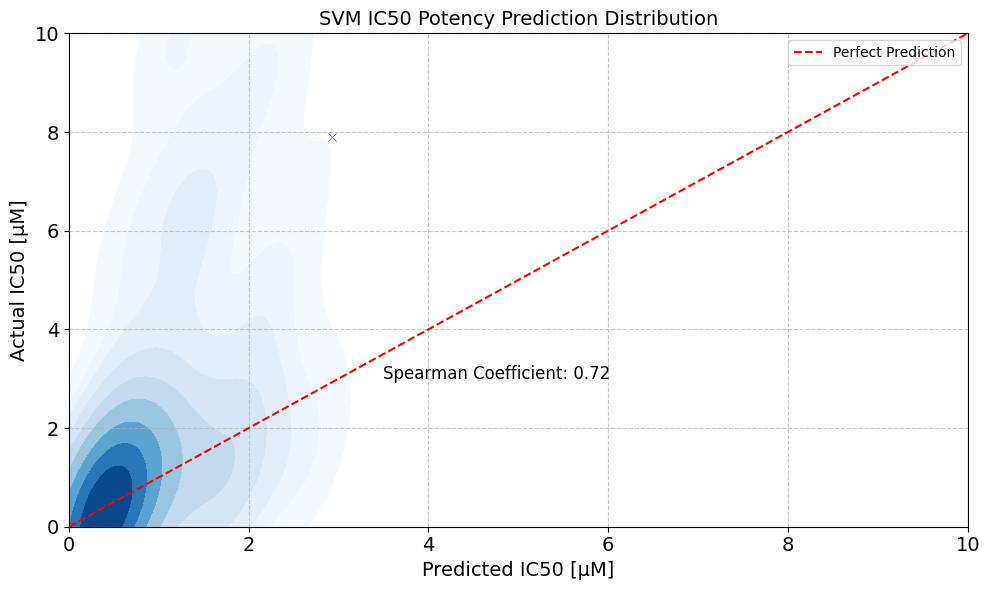

In [ ]:
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

# Calculate residuals
residuals = y_test - y_pred1

# Calculate Spearman correlation coefficient
spearman_coefficient, _ = spearmanr(y_test, y_pred1)

# Create scatter plot with density plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred1, y=y_test, color='navy', alpha=0.7, marker='x')
sns.kdeplot(x=y_pred1, y=y_test, cmap='Blues', fill=True, thresh=0.05, label='Density Plot')

# Plot diagonal line for perfect predictions
plt.plot([0, y_test.max()], [0, y_test.max()], color='red', linestyle='--', label='Perfect Prediction')

# Annotate Spearman coefficient
plt.text(0.7 * y_test.max()/2, 0.9 * y_test.max()/3, f'Spearman Coefficient: {spearman_coefficient:.2f}', fontsize=12)

plt.xlabel('Predicted IC50 [µM]', fontsize = 14)
plt.ylabel('Actual IC50 [µM]', fontsize = 14)
plt.title('SVM IC50 Potency Prediction Distribution', fontsize = 14)

# Set axes limits to start at 0
plt.xlim(0, y_test.max())
plt.ylim(0, y_test.max())
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

# Add legend
plt.legend(loc='upper right')

plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('dist_1.png', dpi = 600)
plt.show()



In [ ]:
model2 = CatBoostRegressor(logging_level='Silent', random_state = 1)
model2.fit(X_train, y_train)
y_pred2 = model2.predict(X_test)

In [ ]:

# # Calculate residuals
# residuals = y_test - y_pred

# # Calculate Spearman correlation coefficient
# spearman_coefficient, _ = spearmanr(y_test, y_pred)

# # Create scatter plot with density plot
# plt.figure(figsize=(10, 6))
# sn.scatterplot(x=y_pred, y=y_test, color='navy', alpha=0.7, marker='x')
# sn.kdeplot(x=y_pred, y=y_test, cmap='Blues', fill=True, thresh=0.05, label='Density Plot')

# # Plot diagonal line for perfect predictions
# plt.plot([0, y_test.max()], [0, y_test.max()], color='red', linestyle='--', label='Perfect Prediction')

# plt.text(0.7 * y_test.max()/2, 0.9 * y_test.max()/3, f'Spearman Coefficient: {spearman_coefficient:.2f}', fontsize=12)

# plt.xlabel('Predicted IC50 [µM]', fontsize = 14)
# plt.ylabel('Actual IC50 [µM]', fontsize = 14)
# plt.title('CatBoost IC50 Potency Prediction Distribution', fontsize = 14)

# # Set axes limits to start at 0
# plt.xlim(0, y_test.max())
# plt.ylim(0, y_test.max())
# plt.xticks(fontsize = 14)
# plt.yticks(fontsize = 14)

# # Add legend
# plt.legend(loc='upper right')

# plt.grid(True, linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.savefig('dist_2.png', dpi = 600)
# plt.show()


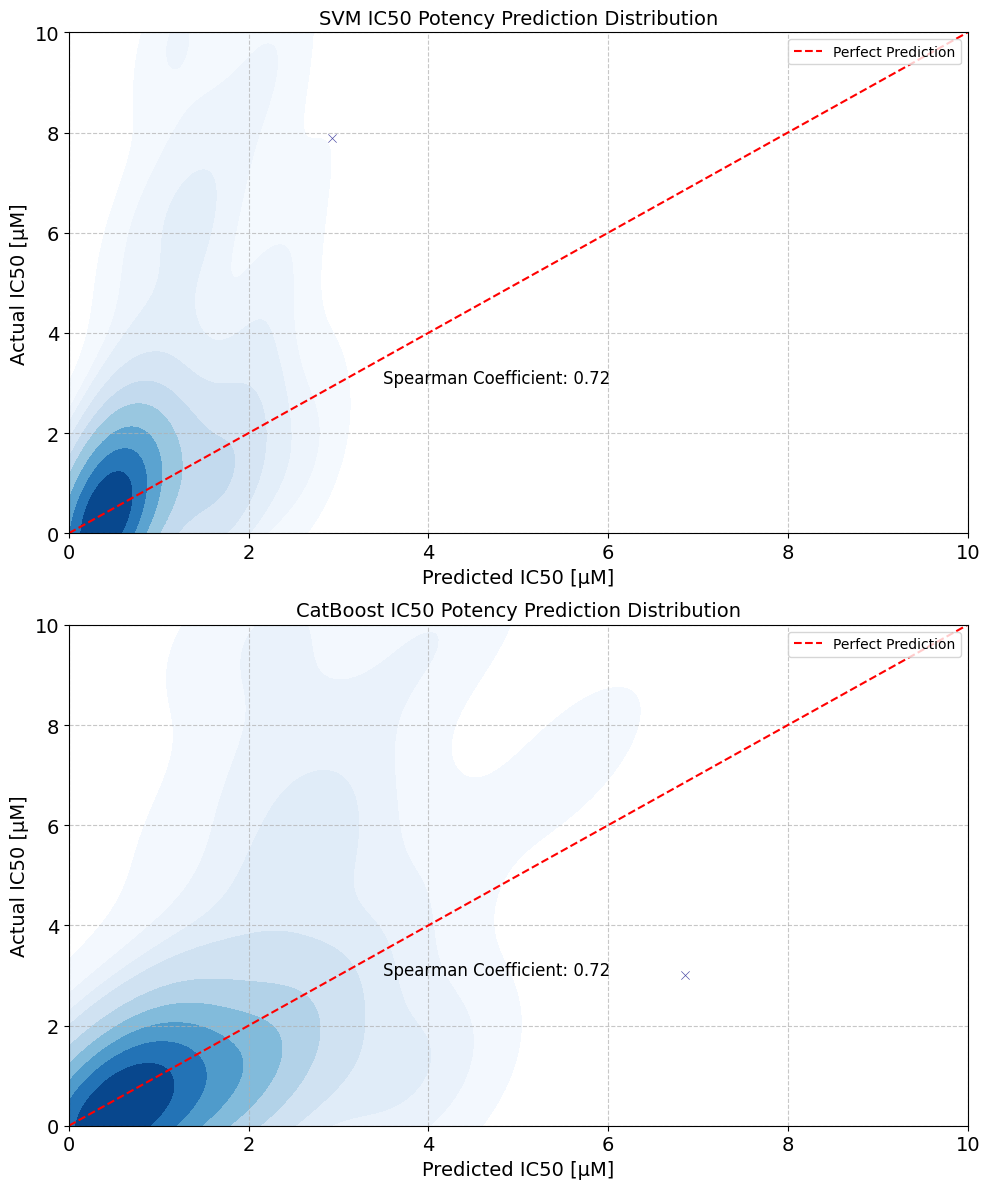

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# Assuming y_test, y_pred1, and y_pred2 are already defined
# Calculate residuals and Spearman correlation coefficient for both models
residuals_1 = y_test - y_pred1
spearman_coefficient_1, _ = spearmanr(y_test, y_pred1)

residuals_2 = y_test - y_pred2
spearman_coefficient_2, _ = spearmanr(y_test, y_pred2)

# Create a figure with 2 vertical subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 12))

# First subplot for SVM
sns.scatterplot(ax=axes[0], x=y_pred1, y=y_test, color='navy', alpha=0.7, marker='x')
sns.kdeplot(ax=axes[0], x=y_pred1, y=y_test, cmap='Blues', fill=True, thresh=0.05, label='Density Plot')
axes[0].plot([0, y_test.max()], [0, y_test.max()], color='red', linestyle='--', label='Perfect Prediction')
axes[0].text(0.7 * y_test.max()/2, 0.9 * y_test.max()/3, f'Spearman Coefficient: {spearman_coefficient_1:.2f}', fontsize=12)
axes[0].set_xlabel('Predicted IC50 [µM]', fontsize=14)
axes[0].set_ylabel('Actual IC50 [µM]', fontsize=14)
axes[0].set_title('SVM IC50 Potency Prediction Distribution', fontsize=14)
axes[0].set_xlim(0, y_test.max())
axes[0].set_ylim(0, y_test.max())
axes[0].tick_params(axis='both', which='major', labelsize=14)
axes[0].legend(loc='upper right')
axes[0].grid(True, linestyle='--', alpha=0.7)

# Second subplot for CatBoost
sns.scatterplot(ax=axes[1], x=y_pred2, y=y_test, color='navy', alpha=0.7, marker='x')
sns.kdeplot(ax=axes[1], x=y_pred2, y=y_test, cmap='Blues', fill=True, thresh=0.05, label='Density Plot')
axes[1].plot([0, y_test.max()], [0, y_test.max()], color='red', linestyle='--', label='Perfect Prediction')
axes[1].text(0.7 * y_test.max()/2, 0.9 * y_test.max()/3, f'Spearman Coefficient: {spearman_coefficient_2:.2f}', fontsize=12)
axes[1].set_xlabel('Predicted IC50 [µM]', fontsize=14)
axes[1].set_ylabel('Actual IC50 [µM]', fontsize=14)
axes[1].set_title('CatBoost IC50 Potency Prediction Distribution', fontsize=14)
axes[1].set_xlim(0, y_test.max())
axes[1].set_ylim(0, y_test.max())
axes[1].tick_params(axis='both', which='major', labelsize=14)
axes[1].legend(loc='upper right')
axes[1].grid(True, linestyle='--', alpha=0.7)

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('combined_dist.png', dpi=600)
plt.show()



In [ ]:
import pickle
pickle.dump(model2, open("model2.pkl", 'wb'))

In [ ]:
full_preds = model2.predict(sc.transform(X))
df_wa = pd.DataFrame(full_preds)

df_wa["Smiles"] = df2["Smiles"]
df_wa.to_csv('ic50_full_data.csv', index = False)
df_wa


,0,Smiles
0,0.714960,Cc1sc2nc(SCC(=O)NN)n(-c3ccccc3)c(=O)c2c1-c1ccccc1
1,0.447101,NNC(=O)CSc1nc2sc3c(c2c(=O)n1-c1cccc(F)c1)C(c1c...
2,0.213584,NNC(=O)CSc1nc2sc(Cl)c(-c3ccccc3F)c2c(=O)n1-c1c...
3,0.224447,COc1ccc(-c2csc3nc(SCC(=O)NN)n(-c4cccc(F)c4)c(=...
4,4.166322,NNC(=O)CSc1nc2scc(-c3ccccc3)c2c(=O)n1-c1ccccc1
...,...,...
419,0.324032,COC(=O)C=CCCC(NC(=O)c1cc([N+](=O)[O-])ccc1C(=O...
420,2.277799,COC(=O)C=CCCC(NC(=O)c1ccccc1C(=O)O)C(=O)Nc1ccc...
421,2.439880,CCCCC(NC(=O)C(CCC=CC(=O)OC)NC(=O)c1ccccc1C(=O)...
422,2.296338,CCCCC(NC(=O)C(CCC=CC(=O)OC)NC(=O)c1ccccc1C(=O)...


In [ ]:
print(rdkit. __version__)

2023.09.6
